In [1]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image

######################################
from matplotlib import pyplot as plt

In [2]:
#df = pd.read_csv("compas-scores-two-years-violent.csv", index_col=0)
df = pd.read_csv("compas-scores-two-years.csv", index_col=0)


In [ ]:
y = df['two_year_recid']
keep_cols = [
    'age',             # defendant age
    'sex',             # male/female
    'race',            # categorical
    'priors_count',    # number of prior offenses
    'c_charge_degree'  # felony vs misdemeanor
]

X_safe = df[keep_cols].copy()

# One‐hot encode the categoricals
X= pd.get_dummies(X_safe, drop_first=True)

#  Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)

#  Make predictions
y_pred = rf.predict(X_test)

Accuracy: 0.64
Precision: 0.58
Recall: 0.58


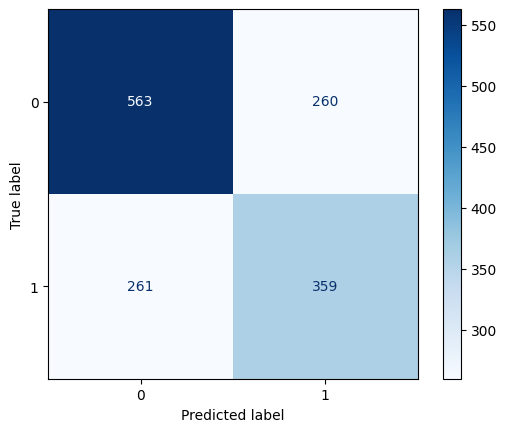

In [4]:
#  Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
disp = ConfusionMatrixDisplay(confusion, display_labels=rf.classes_)
disp.plot(cmap='Blues')
plt.show()

In [5]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_curve, auc

In [6]:
kfold = KFold(n_splits = 20, shuffle=True)
scores = cross_val_score(estimator=rf, X=X, y=y, scoring="accuracy", cv=kfold)
cross_val_accuracy = cross_val_score(estimator=rf, X=X, y=y, scoring="accuracy", cv=kfold)
cross_val_accuracy_mean = np.mean(cross_val_accuracy)
cross_val_accuracy_std = np.std(cross_val_accuracy)

print(f"K-fold validation score {scores}")
print(f"Average k-fold validation score : {scores.mean()}")
print(f"Average error on fold: {cross_val_accuracy_mean}")
print(f"Standard error on fold: {cross_val_accuracy_std}")

K-fold validation score [0.62880886 0.60387812 0.62049861 0.59556787 0.59556787 0.62880886
 0.64542936 0.66204986 0.63434903 0.66481994 0.66481994 0.6066482
 0.63157895 0.6398892  0.63055556 0.59722222 0.625      0.60555556
 0.65277778 0.62222222]
Average k-fold validation score : 0.6278024007386888
Average error on fold: 0.6279655278547244
Standard error on fold: 0.02947140486812813


In [11]:
kfold = KFold(n_splits = 20, shuffle=True)
scores = cross_val_score(estimator=rf, X=X, y=y, scoring="precision", cv=kfold)
cross_val_precision = cross_val_score(estimator=rf, X=X, y=y, scoring="precision", cv=kfold)
cross_val_precision_mean = np.mean(cross_val_precision)
cross_val_precision_std = np.std(cross_val_precision)

print(f"K-fold validation score {scores}")
print(f"Average k-fold validation score : {scores.mean()}")
print(f"Average error on fold: {cross_val_precision_mean}")
print(f"Standard error on fold: {cross_val_precision_std}")

K-fold validation score [0.59333333 0.60402685 0.57232704 0.60264901 0.64197531 0.60220994
 0.59589041 0.59064327 0.61392405 0.56164384 0.60869565 0.525
 0.55555556 0.56410256 0.68493151 0.60784314 0.55900621 0.58333333
 0.5890411  0.5617284 ]
Average k-fold validation score : 0.5908930253237925
Average error on fold: 0.5866422345598613
Standard error on fold: 0.038664534462830025


In [12]:
kfold = KFold(n_splits = 20, shuffle=True)
scores = cross_val_score(estimator=rf, X=X, y=y, scoring="recall", cv=kfold)
cross_val_recall = cross_val_score(estimator=rf, X=X, y=y, scoring="recall", cv=kfold)
cross_val_recall_mean = np.mean(cross_val_recall)
cross_val_recall_std = np.std(cross_val_recall)

print(f"K-fold validation score {scores}")
print(f"Average k-fold validation score : {scores.mean()}")
print(f"Average error on fold: {cross_val_recall_mean}")
print(f"Standard error on fold: {cross_val_recall_std}")

K-fold validation score [0.55172414 0.59171598 0.59876543 0.59756098 0.57988166 0.60666667
 0.56707317 0.58783784 0.57615894 0.53488372 0.5497076  0.61212121
 0.52795031 0.55737705 0.64457831 0.56329114 0.53741497 0.52694611
 0.58333333 0.57792208]
Average k-fold validation score : 0.5736455313529465
Average error on fold: 0.571627080603118
Standard error on fold: 0.04703993902594171


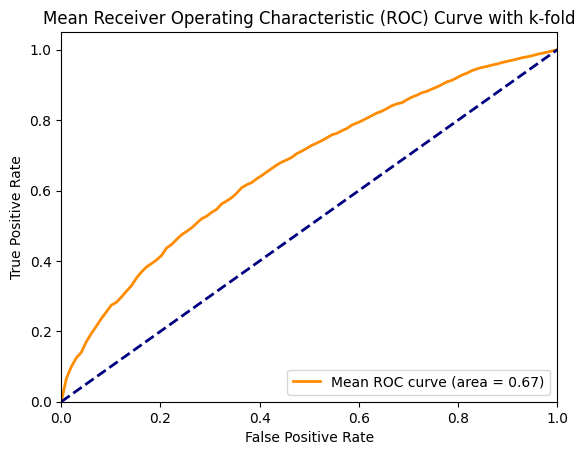

In [ ]:
kfold = KFold(n_splits=20, shuffle=True)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for train_index, test_index in kfold.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    rf.fit(X_train_fold, y_train_fold)
    
    proba_matrix_fold = rf.predict_proba(X_test_fold)
    fpr, tpr, thresholds = roc_curve(y_test_fold, proba_matrix_fold[:, 1])
    
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    
mean_tpr /= kfold.get_n_splits()

roc_auc = auc(mean_fpr, mean_tpr)

plt.figure()
plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, label='Mean ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean Receiver Operating Characteristic (ROC) Curve with k-fold')
plt.legend(loc="lower right")
plt.show()